In [50]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))  # Go up one directory

from llm_provider import LLM_provider
from langchain_community.document_loaders import PyPDFLoader
from langchain_chroma import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter 
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel,Field
from typing import TypedDict,Annotated,Sequence
from langchain_core.messages import BaseMessage
import operator
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import (
    RunnablePassthrough
)
from langgraph.graph import StateGraph,START,END,MessagesState
from IPython.display import Image,display
from langchain.agents import tool
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
llm=LLM_provider()
model=llm.get_llm()


In [51]:
@tool
def multiply(a:int,b:int)->int:
    '''This tool is for multiplication of 2 numbers'''
    return a*b

@tool
def add(a:int,b:int)->int:
    '''This tool is for addition of 2 numbers'''
    return a+b


@tool
def divide(a:int,b:int)->float:
    '''This tool is for division of 2 numbers'''
    if b==0:
        raise ValueError("Denominator cannot be zero")
    return a / b



In [52]:
search=DuckDuckGoSearchRun()
# search.invoke("who is elon musk")

In [53]:
import yfinance as yf
@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from yahoo finance.

    Args:
        ticker(str):The stock ticker symbol(e.g 'AAPL','TSLA')
    Returns:
        str: A message with sticks previosu closing rate
    """
    try:
        stock=yf.Ticker(ticker)
        price=stock.info.get('previousClose')
        if price is None:
            return f"could not fetch price for ticker {ticker}"
        return f"The last closing price if {ticker.upper()} was ${price:.2f}"
    except Exception as e:
        return f"An error occured while fetching stock data {str(e)}"

In [54]:
tools=[add,multiply,divide,search,get_stock_price]

In [55]:
llm_with_tools=model.bind_tools(tools)

In [56]:
System_Prompt="""You are a helpful asssitant tasked with using search and performing arithmetic on a set of inputs."""

In [57]:
def function_1(state:MessagesState):
    print(f"Message state is : {state['messages']}")
    user_question=state["messages"]
    input_question=[System_Prompt]+user_question
    response=llm_with_tools.invoke(input_question)
    return {
        "messages":[response]
    }

In [58]:
builder=StateGraph(MessagesState)

In [59]:
builder.add_node("llm_decision_step",function_1)

In [60]:
ToolNode(tools)

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'store': ('store', None)}, tools_by_name={'add': StructuredTool(name='add', description='This tool is for addition of 2 numbers', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x000002635C673100>), 'multiply': StructuredTool(name='multiply', description='This tool is for multiplication of 2 numbers', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002635C672980>), 'divide': StructuredTool(name='divide', description='This tool is for division of 2 numbers', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x000002635C673F60>), 'duckduckgo_search': DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text')), 'get_stock_price': StructuredTool(name='get_stock_price', descript

In [61]:
builder.add_node("tools",ToolNode(tools))

In [62]:
builder.add_edge(START,"llm_decision_step")

In [63]:
builder.add_conditional_edges("llm_decision_step",tools_condition)

In [64]:
builder.add_edge("tools","llm_decision_step")

In [65]:
app=builder.compile()

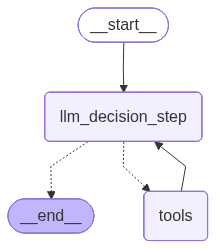

In [66]:
display(Image(app.get_graph().draw_mermaid_png()))

In [67]:
app.invoke({"messages":["what is the stock price of Cholafin and also add 100 to it"]})

Message state is : [HumanMessage(content='what is the stock price of Cholafin and also add 100 to it', additional_kwargs={}, response_metadata={}, id='492e5ad1-ffed-43c6-88fb-a33236ba224d')]
Message state is : [HumanMessage(content='what is the stock price of Cholafin and also add 100 to it', additional_kwargs={}, response_metadata={}, id='492e5ad1-ffed-43c6-88fb-a33236ba224d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q8OpS6iXRNCpX1Nf1ttvd2qf', 'function': {'arguments': '{"ticker":"CHOLAFIN"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 255, 'total_tokens': 274, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_3eed281ddb', 'id': 'chatcmpl-CMvK

{'messages': [HumanMessage(content='what is the stock price of Cholafin and also add 100 to it', additional_kwargs={}, response_metadata={}, id='492e5ad1-ffed-43c6-88fb-a33236ba224d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q8OpS6iXRNCpX1Nf1ttvd2qf', 'function': {'arguments': '{"ticker":"CHOLAFIN"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 255, 'total_tokens': 274, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_3eed281ddb', 'id': 'chatcmpl-CMvKTFgSqiDZVMpUqPesPbJrOWT8d', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered

# AI Travel Agent & Expense Planner Assignment

**Purpose:** Trip planning for any city worldwide with real-time data

## Features Required

- Real-time weather information
- Top attractions and activities
- Hotel cost calculation (per day × total days)
- Currency conversion to user's native currency
- Complete itinerary generation
- Total expense calculation
- Generate a summary of the entire output

---

## System Architecture Flow

```
User Input
    ↓
┌─────────────────────────────────────┐
│ Search Attractions & Activities     │
│  1. Search attractions              │
│  2. Search restaurants              │
│  3. Search activities               │
│  4. Search transportation           │
└─────────────────────────────────────┘
    ↓
┌─────────────────────────────────────┐
│ Weather Forecasting                 │
│  1. Get current weather             │
│  2. Get weather forecast            │
└─────────────────────────────────────┘
    ↓
┌─────────────────────────────────────┐
│ Search Hotel Costs                  │
│  1. Search hotels                   │
│  2. Estimate hotel cost             │
│  3. Determine budget range          │
└─────────────────────────────────────┘
    ↓
┌─────────────────────────────────────┐
│ Calculate Total Cost                │
│  1. Add costs                       │
│  2. Multiply (days × daily rates)   │
│  3. Calculate total cost            │
│  4. Calculate daily budget          │
└─────────────────────────────────────┘
    ↓
┌─────────────────────────────────────┐
│ Currency Conversion                 │
│  1. Get exchange rate               │
│  2. Convert currency                │
└─────────────────────────────────────┘
    ↓
┌─────────────────────────────────────┐
│ Itinerary Generation                │
│  1. Generate day plan               │
│  2. Create full itinerary           │
└─────────────────────────────────────┘
    ↓
┌─────────────────────────────────────┐
│ Create Trip Summary                 │
└─────────────────────────────────────┘
    ↓
Return Complete Travel Plan
```

---

## Implementation Guidelines

**Note:** Design this entire system using **Object-Oriented Programming (OOP)** principles with classes and objects in a modular fashion.

---

In [78]:
# ===== ATTRACTIONS (OpenTripMap API) =====
@tool
def search_attractions(city: str) -> str:
    """
    Search for top tourist attractions in a city using OpenTripMap API.
    
    Args:
        city: Name of the city
    
    Returns:
        String containing tourist attractions with descriptions
    """
    pass  # Will use OpenTripMap API

# ===== RESTAURANTS (DuckDuckGo - no dedicated free API) =====
@tool
def search_restaurants(city: str) -> str:
    """
    Search for popular restaurants in a city.
    
    Args:
        city: Name of the city
    
    Returns:
        String containing restaurant recommendations
    """
    pass  # Will use DuckDuckGo search

# ===== ACTIVITIES (DuckDuckGo) =====
@tool
def search_activities(city: str) -> str:
    """
    Search for activities and things to do in a city.
    
    Args:
        city: Name of the city
    
    Returns:
        String containing activities and experiences
    """
    pass  # Will use DuckDuckGo search

# ===== TRANSPORTATION (DuckDuckGo) =====
@tool
def search_transportation(city: str) -> str:
    """
    Search for transportation options and costs in a city.
    
    Args:
        city: Name of the city
    
    Returns:
        String containing transportation info (metro, bus, taxi costs)
    """
    pass  # Will use DuckDuckGo search

In [79]:
# ===== WEATHER (OpenWeatherMap API) =====
@tool
def get_weather_forecast(city: str, days: int) -> str:
    """
    Get weather forecast for a city using OpenWeatherMap API.
    Note: Free tier provides 5-day forecast maximum.
    
    Args:
        city: Name of the city
        days: Number of days to forecast (max 5 for free tier)
    
    Returns:
        String containing weather forecast
    """
    pass  # Will use OpenWeatherMap API

In [80]:
# ===== HOTELS (DuckDuckGo) =====
@tool
def search_hotels(city: str, budget_type: str) -> str:
    """
    Search for hotels in a city.
    
    Args:
        city: Name of the city
        budget_type: Type of accommodation ("budget", "mid-range", "luxury")
    
    Returns:
        String containing hotel options with estimated prices
    """
    pass  # Will use DuckDuckGo search

In [81]:
# ===== CURRENCY (ExchangeRate-API) =====
@tool
def get_exchange_rate(from_currency: str, to_currency: str) -> str:
    """
    Get current exchange rate between two currencies using ExchangeRate-API.
    
    Args:
        from_currency: Source currency code (e.g., "USD", "EUR", "INR")
        to_currency: Target currency code (e.g., "USD", "EUR", "INR")
    
    Returns:
        String containing the exchange rate
    """
    pass  # Will use ExchangeRate-API

@tool
def convert_currency(amount: float, from_currency: str, to_currency: str) -> str:
    """
    Convert amount from one currency to another using ExchangeRate-API.
    
    Args:
        amount: Amount to convert
        from_currency: Source currency code (e.g., "USD", "EUR", "INR")
        to_currency: Target currency code (e.g., "USD", "EUR", "INR")
    
    Returns:
        String containing converted amount
    """
    pass  # Will use ExchangeRate-API

In [82]:
# ===== CALCULATION TOOLS (No API needed) =====
@tool
def calculate_total_cost(hotel_cost: float, food_cost: float, transport_cost: float, activity_cost: float) -> float:
    """
    Calculate total trip cost by summing all expenses.
    
    Args:
        hotel_cost: Total hotel cost
        food_cost: Estimated food cost
        transport_cost: Estimated transportation cost
        activity_cost: Estimated activities cost
    
    Returns:
        Total cost as float
    """
    pass

@tool
def calculate_daily_budget(total_cost: float, days: int) -> float:
    """
    Calculate average daily budget.
    
    Args:
        total_cost: Total trip cost
        days: Number of days
    
    Returns:
        Daily budget as float
    """
    pass

In [83]:
# Summary: Free APIs to Use
# Feature	API	Free Tier	API Key Required
# Attractions	OpenTripMap	Unlimited	Yes (free signup)
# Restaurants	DuckDuckGo	Unlimited	No
# Activities	DuckDuckGo	Unlimited	No
# Transportation	DuckDuckGo	Unlimited	No
# Weather	OpenWeatherMap	1000/day	Yes (free signup)
# Hotels	DuckDuckGo	Unlimited	No
# Currency	ExchangeRate-API	1500/month	Yes (free signup)
